# Introduction
This is a Graph Convolutional Networks (GCN) to predict adsorption energy by density of states of mentals.

# Function

In [31]:
import sys
import pickle
import spektral
import visualkeras
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from spektral import models
from spektral.models.gnn_explainer import GNNExplainer
from spektral.data import Graph, Dataset, DisjointLoader
from spektral.layers import ECCConv, GlobalSumPool, GlobalAvgPool

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import (
    Input,
    BatchNormalization,
    Dropout,
    Dense,
    AveragePooling1D,
    Concatenate,
    Conv1D,
    Flatten,
)
from tensorflow.keras.models import Model

sys.executable

# TSNE PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [32]:
tf.config.run_functions_eagerly(True)
print(tf.executing_eagerly())

True


In [33]:
def calculate_d_band(energy, total_density):
    # total_density = np.sum(densities, axis=1)
    area = np.trapz(total_density, energy)
    # print(area)
    center = np.trapz(energy * total_density, energy) / area

    m = []
    m.append(area)
    m.append(center)
    for i in range(5):
        j = i + 2
        # j阶中心矩
        moment = np.trapz((energy - center) ** j * total_density, energy) / area
        m.append(moment)
    return m

In [34]:
def cal_d(energies, densities):

    # 将能量和态密度数据转换为NumPy数组
    energies_arr = np.array(energies)
    densities_arr = np.array(densities)
    area = np.trapz(densities, energies)
    # 计算中心（平均值）
    center = np.sum(energies_arr * densities_arr) / np.sum(densities_arr)

    # 计算方差
    variance = np.sum(densities_arr * (energies_arr - center) ** 2) / np.sum(
        densities_arr
    )
    deviation = np.sqrt(variance)
    # 计算偏度
    skewness = np.sum(densities_arr * (energies_arr - center) ** 3) / (
        np.sum(densities_arr) * variance ** (3 / 2)
    )
    ss = np.sign(skewness) * np.power(np.abs(skewness), 1 / 3)
    # 计算峰度
    kurtosis = (
        np.sum(densities_arr * (energies_arr - center) ** 4)
        / (np.sum(densities_arr) * variance**2)
        - 3
    )
    sk = np.power(kurtosis + 3.0, 1 / 4) - np.power(3, 1 / 4)
    m = [area, center, deviation, ss, sk]
    return m

# Load Data

In [35]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """

    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def download(self):
        if self.path is None:
            print("self.path is None")
        else:
            with open(self.path, "wb") as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(self.graph_list[i])
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [36]:
dos_energy_data_file = (
    "/media/zwbai/DATA/dft/alloy_copy/vasp_cal/dos_energy_data_all.pkl"
)
with open(dos_energy_data_file, "rb") as file:
    graph_data = pickle.load(file)
print(graph_data)  # 输出：[1, 2, 3, 4, 5]
graph_data[0].x.shape

MyGraphDataset(n_graphs=1341)


(8, 4000)

In [37]:
graph_data[:2]

[Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1)]

In [38]:
dband = np.sum(graph_data[0].x[0].reshape(-1, 5), axis=1)
erange = np.linspace(-7, 1, num=dband.shape[0])
dband.shape

(800,)

In [39]:
erange.shape

(800,)

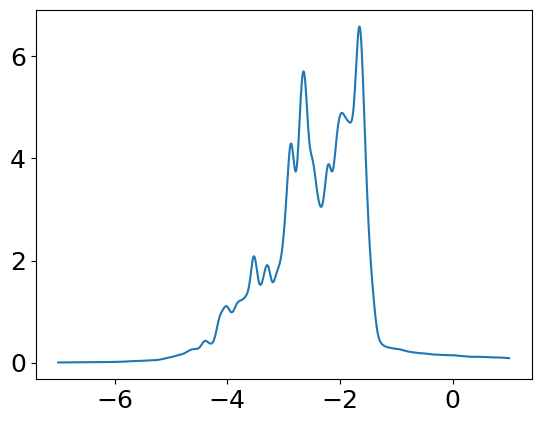

In [40]:
plt.plot(erange, dband)

In [41]:
import copy

graph_data2 = copy.deepcopy(graph_data)
erange = np.linspace(-7, 1, num=dband.shape[0])
for i in range(len(graph_data2)):
    nx = np.zeros((8, 5))
    for j in range(6):
        dband = np.sum(graph_data2[i].x[j].reshape(-1, 5), axis=1)
        m = np.array(cal_d(erange, dband))  # 计算d带特征
        nx[j, :] = m
    graph_data2[i].x = nx
dataset = MyGraphDataset(graph_data2)

In [42]:
graph_data2[1000].x

array([[ 1.12399845e-01, -1.30575299e+00,  2.00700654e+00,
        -9.59162388e-01, -2.20148504e-02],
       [ 1.69917546e+00, -1.88092597e+00,  2.16508295e+00,
        -7.64837896e-01, -1.22122013e-01],
       [ 9.88177542e+00, -2.18345631e+00,  2.12964622e+00,
        -7.42527683e-01, -1.10415315e-01],
       [ 3.33644706e+01, -2.99768072e+00,  2.30238062e+00,
         4.64057482e-01, -1.67482551e-01],
       [ 1.01057173e+01, -5.34943222e+00,  1.71564639e+00,
         1.18889693e+00,  2.15921444e-01],
       [ 8.84576771e-01, -3.41382427e+00,  2.23203349e+00,
         6.87631803e-01, -1.12513925e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

In [43]:
dband = np.sum(graph_data[0].x[0].reshape(-1, 5), axis=1)
erange = np.linspace(-7, 1, num=dband.shape[0])
np.array(cal_d(erange, dband))

array([ 9.25613448, -2.42927478,  0.88888093, -0.53800804,  0.13687317])

# New GCN model

In [44]:
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target
F, S, n_out

(5, 4, 1)

In [45]:
learning_rate = 1e-4  # Learning rate
epochs = 40  # Number of training epochs
batch_size = 8  # Batch size

In [46]:
channels = 5
length = int(F / channels)  # 400

In [47]:
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = ECCConv(256, activation="relu")
        self.conv2 = ECCConv(128, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense0 = Dense(64)
        self.dense = Dense(n_out)

    def call(self, inputs):
        x, a, e, i = inputs
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool([x, i])
        output = self.dense0(output)
        output = self.dense(output)

        return output

In [48]:
model = Net()
model.layers

In [49]:
learning_rate = 1e-3
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

# Train/valid/test split
data = np.array(graph_data2)
idxs = np.random.permutation(len(data))
split_va_te = int(0.90 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

loader_tr = DisjointLoader(
    MyGraphDataset(data_tr), batch_size=batch_size, epochs=epochs
)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)

In [50]:
# Fit model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [51]:
istrain = False
if istrain:
    step = loss = 0
    for batch in loader_tr:
        step += 1
        loss += train_step(*batch)
        if step == loader_tr.steps_per_epoch:
            step = 0
            print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
            loss = 0
    model.save_weights("./vasp_cal/model_weightas")  # 保存GCN權重
else:
    model.load_weights("./vasp_cal/model_weightas")  # 加载GCN权重

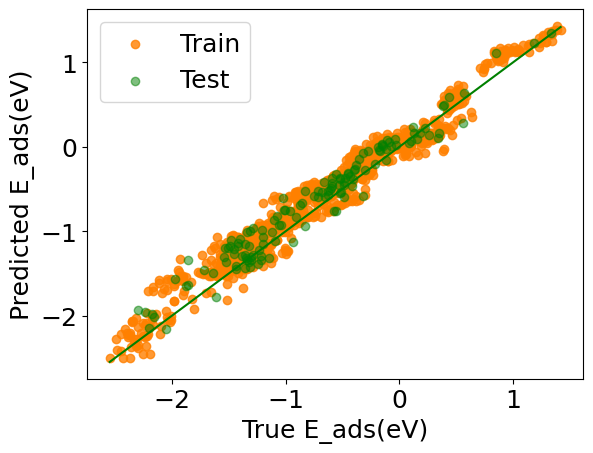

In [52]:
# Train/valid/test split
data = np.array(graph_data2)
idxs = np.random.permutation(len(data))
split_va_te = int(0.9 * len(data))
idx_tr, idx_va = np.split(idxs, [split_va_te])
data_tr = data[idx_tr]
data_va = data[idx_va]

# Data loaders
loader_tr = DisjointLoader(MyGraphDataset(data_tr), batch_size=1, epochs=1)
loader_va = DisjointLoader(MyGraphDataset(data_va), batch_size=1, epochs=1)
# 对训练集进行预测
predictions = []
targets = []
for batch in loader_tr:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
# 组合预测值和真实值
data0 = np.concatenate([predictions, targets], axis=1)

# 对测试集进行预测
predictions = []
targets = []
for batch in loader_va:
    output = model(batch[0], training=False)
    predictions.append(output)
    targets.append(batch[1])
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# 组合预测值和真实值
data1 = np.concatenate([predictions, targets], axis=1)
# 画图
plt.rcParams.update({"font.size": 18})

plt.scatter(data0[:, 1], data0[:, 0], color=(1, 0.5, 0, 0.8), label="Train")
plt.scatter(data1[:, 1], data1[:, 0], color=(0, 0.5, 0, 0.5), label="Test")

plt.plot(
    [min(data0[:, 1]), max(data0[:, 1])],
    [min(data0[:, 1]), max(data0[:, 1])],
    color="green",
)

plt.xlabel("True E_ads(eV)")
plt.ylabel("Predicted E_ads(eV)")
plt.legend()
plt.show()

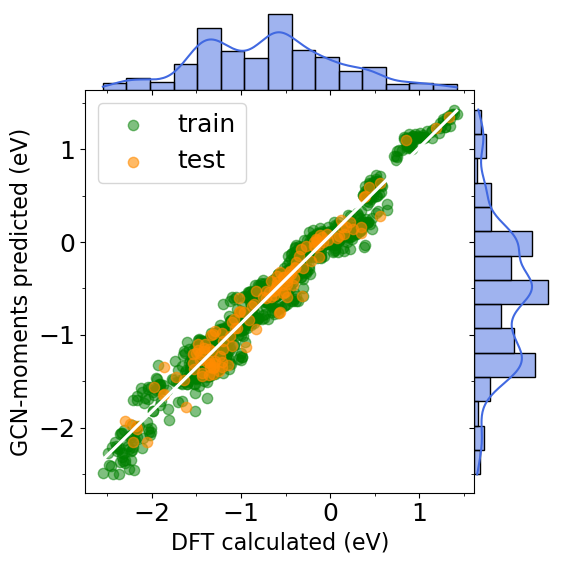

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

e_train, pre_train, e_test, pre_test = (
    data0[:, 1],
    data0[:, 0],
    data1[:, 1],
    data1[:, 0],
)

# 将四列数据拼接为一个Pandas DataFrame
df1 = pd.concat([pd.DataFrame(e_train), pd.DataFrame(pre_train)], axis=1)
# 重置列索引（可选）
df1.columns = ["True", "Predict"]

df2 = pd.concat([pd.DataFrame(e_test), pd.DataFrame(pre_test)], axis=1)
# 重置列索引（可选）
df2.columns = ["True", "Predict"]

new_column_name = "Species"
df1[new_column_name] = "train"
df2[new_column_name] = "test"
result = pd.concat([df1, df2], axis=0, ignore_index=True)

# plt.rcParams['font.family'] = 'Arial'
# 使用jointplot绘制联合分布图
plot = sns.jointplot(
    x="True",
    y="Predict",
    data=result,
    color="w",
    kind="reg",
    space=0.0,
    ratio=5,
    marginal_kws=dict(bins=15, color="royalblue"),
)

# 在联合分布图上添加自定义散点
# 注意：这里为df1和df2的散点图层分别指定了不同的标签
plot.ax_joint.scatter(
    df1["True"], df1["Predict"], alpha=0.5, s=55, label="train", color="g"
)
plot.ax_joint.scatter(
    df2["True"], df2["Predict"], alpha=0.6, s=55, label="test", color="darkorange"
)

# 设置主刻度和副刻度
# 获取x轴和y轴的轴对象
ax_x = plot.ax_marg_x
ax_y = plot.ax_marg_y

# 设置副刻度
# 假设我们想要在主刻度之间添加一个副刻度
# 首先，我们需要获取主刻度的位置
major_locator = ticker.MultipleLocator(1)  # 假设主刻度间隔为1
ax_x.xaxis.set_major_locator(major_locator)
ax_y.yaxis.set_major_locator(major_locator)

# 然后，我们创建一个副刻度定位器，其间隔为主刻度间隔的一半
minor_locator = ticker.MultipleLocator(0.5)  # 副刻度间隔为0.5
ax_x.xaxis.set_minor_locator(minor_locator)
ax_y.yaxis.set_minor_locator(minor_locator)
# 设置主刻度向内

# ax_x.tick_params(axis='x', which='both',  direction='in')
# ax_y.tick_params(axis='y', which='both',  direction='in')

# 添加图例
plot.ax_joint.legend(loc="upper left")
# 设置x和y轴的标签
plot.set_axis_labels("DFT calculated (eV)", "GCN-moments predicted (eV)", fontsize=16)

# 显示图表
plt.show()

In [54]:
import scipy.stats as stats
import math
from sklearn.metrics import mean_squared_error


# 计算 Pearson 相关系数和 p 值
corr, p_value = stats.pearsonr(data0[:, 1], data0[:, 0])

print("Pearson 相关系数:", corr)
print("p 值:", p_value)

# 计算 Pearson 相关系数和 p 值
corr, p_value = stats.pearsonr(data1[:, 1], data1[:, 0])

print("Pearson 相关系数:", corr)
print("p 值:", p_value)

rmse = math.sqrt(mean_squared_error(data0[:, 1], data0[:, 0]))
print("RMSE:", rmse)

rmse = math.sqrt(mean_squared_error(data1[:, 1], data1[:, 0]))
print("RMSE:", rmse)

Pearson 相关系数: 0.9832231659647651
p 值: 0.0
Pearson 相关系数: 0.9780675159022154
p 值: 1.7023835474795086e-92
RMSE: 0.18011595497371818
RMSE: 0.1828595560801885


In [55]:
import shap

In [56]:
def f(X):  # 重新组合实现预测
    # print(X)
    if isinstance(X, np.ndarray):
        x = X
    else:
        x = X.to_numpy()

    datax = []
    for i in range(len(x)):
        data_i = copy.deepcopy(graph_data2[0])
        data_i.x[:6] = x[i]
        datax.append(data_i)
    datasetx = MyGraphDataset(datax)
    loader_x = DisjointLoader(MyGraphDataset(datasetx), batch_size=1, epochs=1)

    pre = []
    for batch in loader_x:
        output = model(batch[0], training=False)

        if isinstance(X, np.ndarray):
            pre.append(output.numpy()[0])
        else:
            pre.append(output.numpy()[0][0])

    return np.array(pre)

In [57]:
graph_data2[0].x

array([[ 9.25613448, -2.42927478,  0.88888093, -0.53800804,  0.13687317],
       [ 9.25613448, -2.42927478,  0.88888093, -0.53800804,  0.13687317],
       [ 9.25613448, -2.42927478,  0.88888093, -0.53800804,  0.13687317],
       [ 9.25613448, -2.42927478,  0.88888093, -0.53800804,  0.13687317],
       [ 9.25613448, -2.42927478,  0.88888093, -0.53800804,  0.13687317],
       [ 9.25613448, -2.42927478,  0.88888093, -0.53800804,  0.13687317],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [58]:
gd = copy.deepcopy(graph_data2[:66])
gdx = np.array([gdi.x[0] for gdi in gd])
gdx = pd.DataFrame(gdx, columns=["Filling", "Center", "Width", "Skew", "Kurtosis"])
gdx

,Filling,Center,Width,Skew,Kurtosis
0,9.256134,-2.429275,0.888881,-0.538008,0.136873
1,9.310979,-2.410489,0.876309,-0.536771,0.141758
2,9.236566,-2.409817,0.878699,-0.534625,0.140215
3,9.276037,-2.409547,0.878893,-0.536786,0.140654
4,9.275599,-2.426075,0.888660,-0.527983,0.135897
...,...,...,...,...,...
61,9.237630,-2.471317,0.912520,-0.513902,0.127083
62,9.271753,-2.470768,0.911764,-0.522709,0.127648
63,9.279854,-2.495985,0.927053,-0.504520,0.120250
64,9.285602,-2.462256,0.908414,-0.513078,0.128293


In [59]:
f(gdx.iloc[:5])

you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


array([-0.862731  , -0.95111215, -0.90607804, -0.9280583 , -0.8553862 ],
      dtype=float32)

In [60]:
explainer = shap.Explainer(f, gdx.iloc[:66])
shap_values = explainer(gdx.iloc[:66])

Exact explainer: 67it [05:12,  4.89s/it]                        


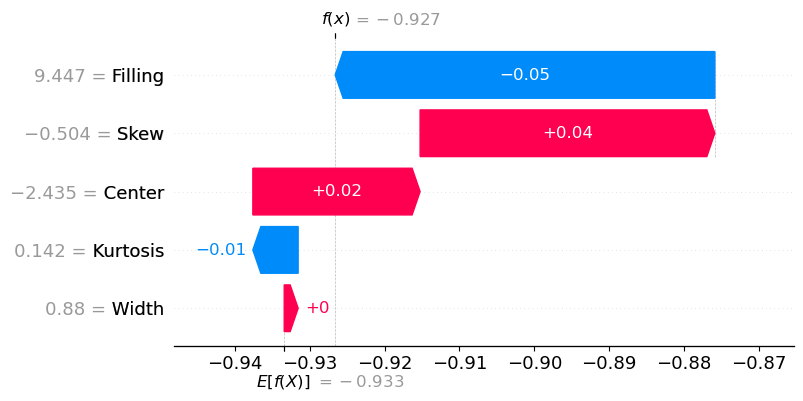

In [61]:
sample_ind = 19
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind])

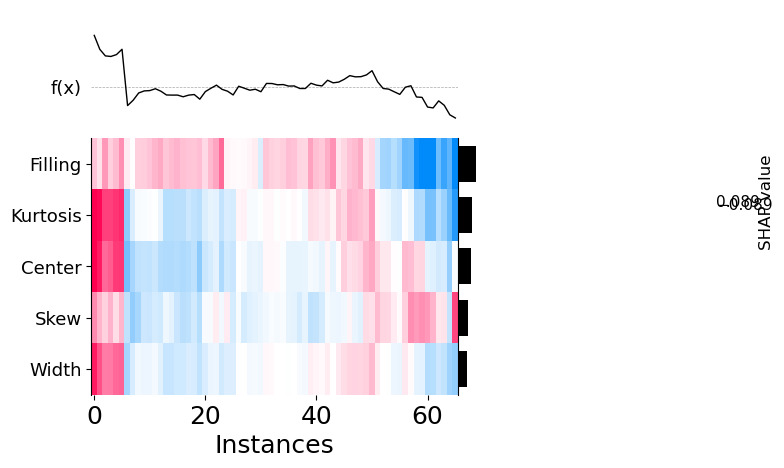

In [ ]:
shap.plots.heatmap(shap_values)

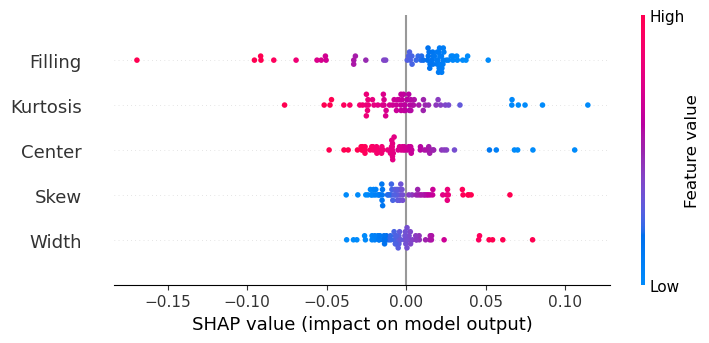

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
gd = copy.deepcopy(graph_data2[66:132])
gdx = np.array([gdi.x[0] for gdi in gd])
gdx = pd.DataFrame(gdx, columns=["Filling", "Center", "Width", "Skew", "Kurtosis"])
gdx
explainer2 = shap.Explainer(f, gdx)
shap_values2 = explainer2(gdx)

you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
Exact explainer: 67it [05:30,  5.16s/it]                        


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


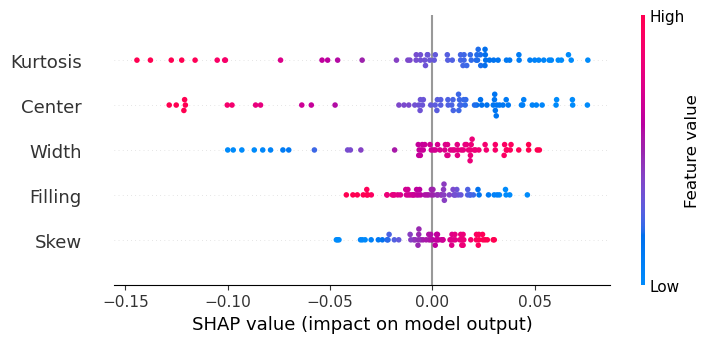

In [ ]:
shap.plots.beeswarm(shap_values2)

In [ ]:
shap_values

.values =
array([[ 2.94211358e-02,  1.54219682e-02,  1.52010444e-02,
        -1.10691380e-02,  2.17191174e-02],
       [ 6.36337241e-03, -7.53586006e-03, -4.10471312e-03,
        -9.20973602e-03, -3.20010667e-03],
       [ 3.76484825e-02, -8.41960063e-03, -4.68887313e-04,
        -6.05093710e-03,  4.63800968e-03],
       [ 2.10492723e-02, -8.71650367e-03, -1.44815776e-04,
        -9.23941206e-03,  2.41824062e-03],
       [ 2.12308614e-02,  1.14869545e-02,  1.48538439e-02,
         3.75580551e-03,  2.67114448e-02],
       [ 1.95600558e-02,  2.88866658e-03,  2.82190087e-03,
        -5.04184340e-03,  2.97183056e-03],
       [ 7.56214005e-03, -4.84049667e-02, -3.09719160e-02,
        -2.18674507e-02, -3.91518447e-02],
       [ 9.41915047e-03,  1.55960329e-03,  8.31858194e-03,
        -6.74348320e-03,  2.01066707e-02],
       [ 2.31540670e-02, -2.74179315e-02, -1.97047374e-02,
        -1.00385627e-02, -2.50083886e-02],
       [ 3.18235606e-02, -9.84290962e-03, -6.78401814e-03,
         6.33

In [ ]:
shap_values.values = np.concatenate((shap_values.values, shap_values2.values), axis=0)

In [ ]:
shap_values.base_values = np.concatenate(
    (shap_values.base_values, shap_values2.base_values), axis=0
)

In [ ]:
shap_values.data = np.concatenate((shap_values.data, shap_values2.data), axis=0)

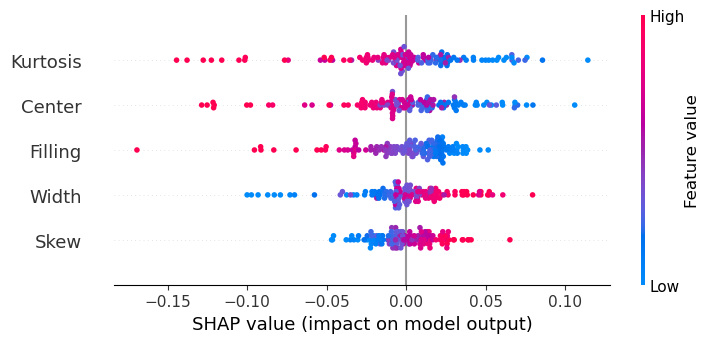

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
9 * 3 * 22

594

you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
Exact explainer: 23it [00:37,  2.19s/it]                        


202


Exact explainer: 23it [00:36,  2.31s/it]                        


224


Exact explainer: 23it [00:37,  2.32s/it]                        


246


Exact explainer: 23it [00:36,  2.30s/it]                        


268


Exact explainer: 23it [00:37,  2.18s/it]                        


290


Exact explainer: 23it [00:37,  2.20s/it]                        


312


Exact explainer: 23it [00:37,  2.20s/it]                        


334


Exact explainer: 23it [00:36,  2.30s/it]                        


356


Exact explainer: 23it [00:37,  2.21s/it]                        


378


Exact explainer: 23it [00:37,  2.36s/it]                        


400


Exact explainer: 23it [00:37,  2.32s/it]                        


422


Exact explainer: 23it [00:38,  2.43s/it]                        


444


Exact explainer: 23it [00:38,  2.24s/it]                        


466


Exact explainer: 23it [00:35,  2.24s/it]                        


488


Exact explainer: 23it [00:35,  2.25s/it]                        


510


Exact explainer: 23it [00:36,  2.29s/it]                        


532


Exact explainer: 23it [00:36,  2.29s/it]                        


554


Exact explainer: 23it [00:36,  2.30s/it]                        


576


Exact explainer: 23it [00:36,  2.28s/it]                        


598


Exact explainer: 23it [00:36,  2.30s/it]                        


620


Exact explainer: 23it [00:36,  2.28s/it]                        


642


Exact explainer: 23it [00:36,  2.27s/it]                        


664


Exact explainer: 23it [00:36,  2.27s/it]                        


686


Exact explainer: 23it [00:36,  2.15s/it]                        


708


Exact explainer: 23it [00:36,  2.27s/it]                        


730


Exact explainer: 23it [00:36,  2.28s/it]                        


752


Exact explainer: 23it [00:36,  2.30s/it]                        
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


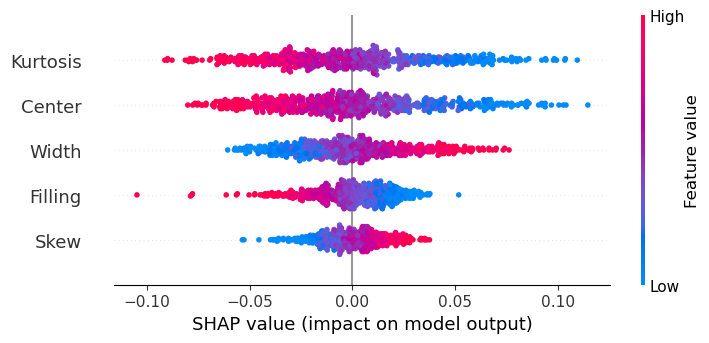

In [ ]:
i = 0
ii = 180 + i * 22
gd = copy.deepcopy(graph_data2[ii : ii + 22])
gdx = np.array([gdi.x[0] for gdi in gd])
gdx = pd.DataFrame(gdx, columns=["Filling", "Center", "Width", "Skew", "Kurtosis"])

explainer = shap.Explainer(f, gdx)
shap_values = explainer(gdx)

for i in range(1, 27):
    ii = 180 + i * 22
    print(ii)
    gd = copy.deepcopy(graph_data2[ii : ii + 22])
    gdx = np.array([gdi.x[0] for gdi in gd])
    gdx = pd.DataFrame(gdx, columns=["Filling", "Center", "Width", "Skew", "Kurtosis"])

    explainer2 = shap.Explainer(f, gdx)
    shap_values2 = explainer2(gdx)

    shap_values.values = np.concatenate(
        (shap_values.values, shap_values2.values), axis=0
    )
    shap_values.base_values = np.concatenate(
        (shap_values.base_values, shap_values2.base_values), axis=0
    )
    shap_values.data = np.concatenate((shap_values.data, shap_values2.data), axis=0)
shap.plots.beeswarm(shap_values)

In [ ]:
gd = copy.deepcopy(graph_data2[180 : 180 + 66])
gdx = np.array([gdi.x[0] for gdi in gd])
gdx = pd.DataFrame(gdx, columns=["Filling", "Center", "Width", "Skew", "Kurtosis"])
gdx

,Filling,Center,Width,Skew,Kurtosis
0,9.310107,-2.433953,0.885178,-0.526960,0.139574
1,9.227387,-2.443088,0.894300,-0.519134,0.135613
2,9.315330,-2.465828,0.906519,-0.512980,0.128893
3,9.389419,-2.491118,0.920464,-0.522612,0.125349
4,9.311877,-2.448001,0.894363,-0.522318,0.134280
...,...,...,...,...,...
61,9.295125,-2.407414,0.876251,-0.543563,0.141919
62,9.352163,-2.448020,0.895550,-0.533060,0.134373
63,9.309815,-2.463533,0.909207,-0.532622,0.129021
64,9.308180,-2.507561,0.931536,-0.517970,0.119623


In [62]:
def f2(X):
    datax = []
    for xi in X:
        data = copy.deepcopy(graph_data2[0])
        data.x[:6] = xi
        datax.append(data)
    loader_x = DisjointLoader(MyGraphDataset(datax), batch_size=1, epochs=1)
    pre = []
    for batch in loader_x:
        output = model(batch[0], training=False)
        pre.append(output.numpy()[0])
    return np.array(pre)

In [74]:
gdx

,Filling,Center,Width,Skew,Kurtosis
0,9.256134,-2.429275,0.888881,-0.538008,0.136873
1,9.310979,-2.410489,0.876309,-0.536771,0.141758
2,9.236566,-2.409817,0.878699,-0.534625,0.140215
3,9.276037,-2.409547,0.878893,-0.536786,0.140654
4,9.275599,-2.426075,0.888660,-0.527983,0.135897
...,...,...,...,...,...
61,9.237630,-2.471317,0.912520,-0.513902,0.127083
62,9.271753,-2.470768,0.911764,-0.522709,0.127648
63,9.279854,-2.495985,0.927053,-0.504520,0.120250
64,9.285602,-2.462256,0.908414,-0.513078,0.128293


In [81]:
explainer3 = shap.KernelExplainer(f, gdx[:])
shap_values3 = explainer3.shap_values(gdx.iloc[19], nsamples=200)
shap_values3[0]

array([-0.050736  ,  0.02235013,  0.00186348,  0.0393897 , -0.00605428])

In [77]:
shap_values3

,Filling,Center,Width,Skew,Kurtosis
0,9.256134,-2.429275,0.888881,-0.538008,0.136873
1,9.310979,-2.410489,0.876309,-0.536771,0.141758
2,9.236566,-2.409817,0.878699,-0.534625,0.140215
3,9.276037,-2.409547,0.878893,-0.536786,0.140654
4,9.275599,-2.426075,0.888660,-0.527983,0.135897
...,...,...,...,...,...
61,9.237630,-2.471317,0.912520,-0.513902,0.127083
62,9.271753,-2.470768,0.911764,-0.522709,0.127648
63,9.279854,-2.495985,0.927053,-0.504520,0.120250
64,9.285602,-2.462256,0.908414,-0.513078,0.128293


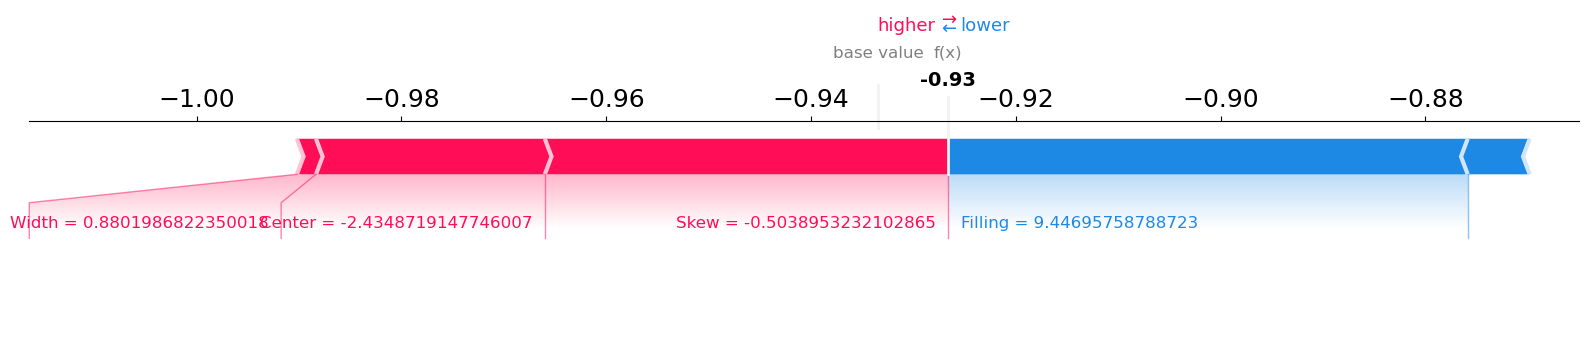

In [82]:
shap.initjs()
shap.force_plot(
    explainer3.expected_value, shap_values3[0], gdx.iloc[19], matplotlib=True
)

In [65]:
shap_values66 = explainer3.shap_values(gdx.iloc[:66], nsamples=200)

  0%|          | 0/66 [00:00<?, ?it/s]

In [66]:
shap.force_plot(
    explainer3.expected_value,
    shap_values66[0],
    gdx.iloc[:66],
)

In [394]:
explainer3.expected_value

-0.8141841780055653

In [396]:
shap_values3[0]

0.002823001597866817

In [395]:
shap.initjs()
shap.force_plot(
    explainer3.expected_value, shap_values3[0], gdx.iloc[-1], matplotlib=True
)

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [352]:
shap_values50 = explainer.shap_values(gdx.iloc[180 : 180 + 66], nsamples=200)
shap.force_plot(explainer.expected_value, shap_values50[0], gdx.iloc[:66])

AttributeError: 'Exact' object has no attribute 'shap_values'

In [353]:
s = 19
shap_values = explainer.shap_values(gdx.iloc[s], nsamples=200)
shap_values

AttributeError: 'Exact' object has no attribute 'shap_values'

In [ ]:
shap.plots.waterfall(shap_values[0])

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

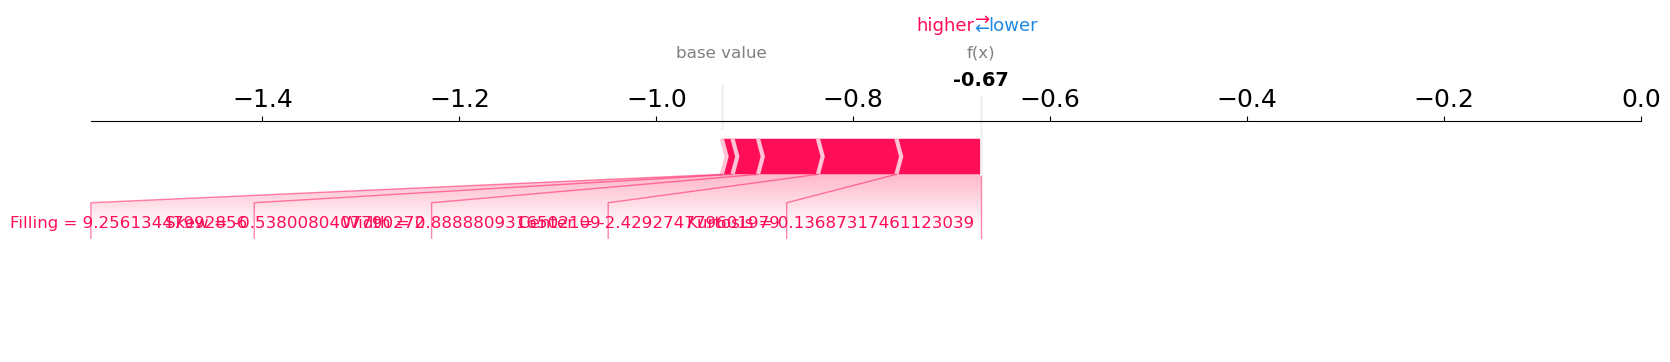

In [154]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[s], gdx.iloc[s], matplotlib=True)

In [104]:
shap_values50 = explainer.shap_values(gdx.iloc[:66], nsamples=200)

  0%|          | 0/66 [00:00<?, ?it/s]

you are shuffling a 'MyGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


In [105]:
shap.force_plot(explainer.expected_value, shap_values50[0], gdx.iloc[:66])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


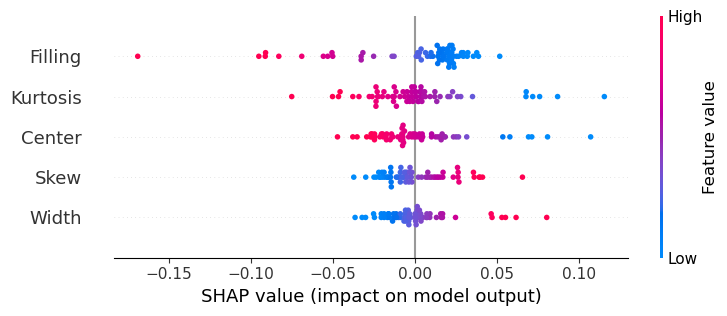

In [106]:
shap.summary_plot(shap_values50[0], gdx.iloc[:66])

In [107]:
gdx["Center"]

0    -2.429275
1    -2.410489
2    -2.409817
3    -2.409547
4    -2.426075
        ...   
61   -2.471317
62   -2.470768
63   -2.495985
64   -2.462256
65   -2.478674
Name: Center, Length: 66, dtype: float64

In [108]:
dert_slab_e = [
    1.2547,
    0.3942,
    -0.6939,
    0.1441,
    -0.5141,
    -0.4464,
    0.0911,
    -1.2456,
    0.2578,
    -0.5141,
    -1.2456,
    -0.6939,
    -0.4464,
]

In [109]:
len(graph_data2)

1341

594 654
654 714


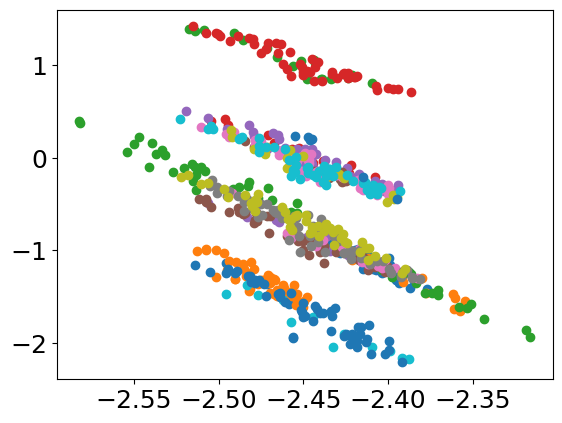

In [110]:
x = np.array([])
y = np.array([])
for i in range(9):
    a = 66 * i
    b = a + 66
    gd = copy.deepcopy(graph_data2[a:b])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:b])
    gdy = np.array([gdi.y for gdi in gd])
    # gdy = gdy-dert_slab_e[i]
    plt.scatter(gdx[:, 1], gdy)
    x = np.concatenate((x, gdx[:, 1]))
    y = np.concatenate((y, gdy))
for j in range(2):
    a = 60 * j + b
    c = a + 60
    print(a, c)
    gd = copy.deepcopy(graph_data2[a:c])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:c])
    gdy = np.array([gdi.y for gdi in gd])
    # gdy = gdy-dert_slab_e[j+i+1]
    plt.scatter(gdx[:, 1], gdy)
    x = np.concatenate((x, gdx[:, 1]))
    y = np.concatenate((y, gdy))
# for k in range(2):
#     a = 30*k + c
#     d = a+30
#     print(a, c)
#     gd = copy.deepcopy(graph_data2[a:d])
#     gdx = np.array([gdi.x[0] for gdi in gd])

#     gd = copy.deepcopy(graph_data2[a:d])
#     gdy = np.array([gdi.y for gdi in gd])
#     gdy = gdy-dert_slab_e[-(k+1)]
#     plt.scatter(gdx[:,1], gdy)

plt.show()

594 654
654 714


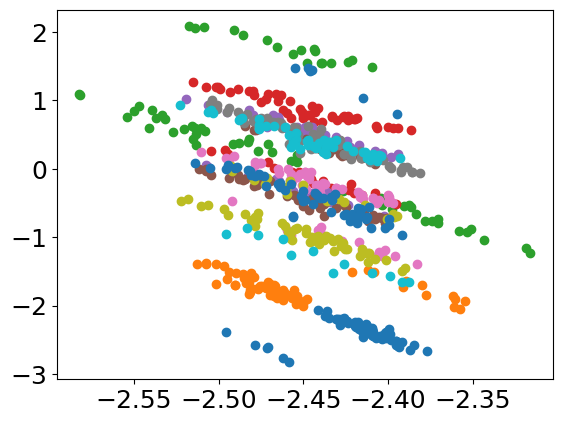

In [111]:
x = np.array([])
y = np.array([])
for i in range(9):
    a = 66 * i
    b = a + 66
    gd = copy.deepcopy(graph_data2[a:b])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:b])
    gdy = np.array([gdi.y for gdi in gd])
    gdy = gdy - dert_slab_e[i]
    plt.scatter(gdx[:, 1], gdy)
    x = np.concatenate((x, gdx[:, 1]))
    y = np.concatenate((y, gdy))
for j in range(2):
    a = 60 * j + b
    c = a + 60
    print(a, c)
    gd = copy.deepcopy(graph_data2[a:c])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:c])
    gdy = np.array([gdi.y for gdi in gd])
    gdy = gdy - dert_slab_e[j + i + 1]
    plt.scatter(gdx[:, 1], gdy)
    x = np.concatenate((x, gdx[:, 1]))
    y = np.concatenate((y, gdy))
# for k in range(2):
#     a = 30*k + c
#     d = a+30
#     print(a, c)
#     gd = copy.deepcopy(graph_data2[a:d])
#     gdx = np.array([gdi.x[0] for gdi in gd])

#     gd = copy.deepcopy(graph_data2[a:d])
#     gdy = np.array([gdi.y for gdi in gd])
#     gdy = gdy-dert_slab_e[-(k+1)]
#     plt.scatter(gdx[:,1], gdy)

plt.show()

In [112]:
import scipy.stats as stats


# 计算 Pearson 相关系数和 p 值
corr, p_value = stats.pearsonr(x, y)

print("Pearson 相关系数:", corr)
print("p 值:", p_value)

Pearson 相关系数: -0.35799887473206
p 值: 5.158852533729936e-23


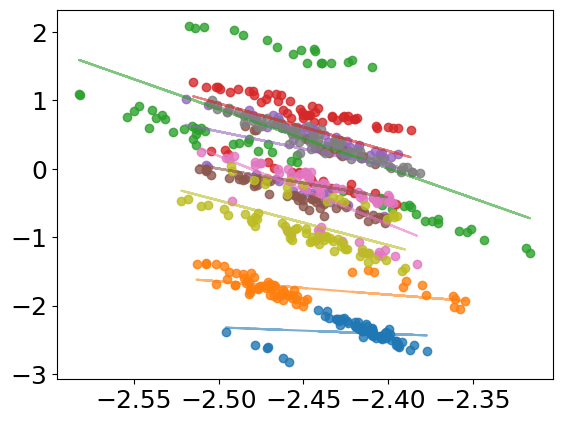

In [113]:
import numpy as np
from scipy.optimize import curve_fit

for i in range(9):
    a = 66 * i
    b = a + 66
    gd = copy.deepcopy(graph_data2[a:b])
    gdx = np.array([gdi.x[0] for gdi in gd])

    gd = copy.deepcopy(graph_data2[a:b])
    gdy = np.array([gdi.y for gdi in gd])
    gdy = gdy - dert_slab_e[i]

    # 获取散点集的默认颜色
    color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

    # 绘制散点
    plt.scatter(gdx[:, 1], gdy, c=color, alpha=0.8)

    # 拟合直线
    def linear_func(x, k, b):
        return k * x + b

    popt, pcov = curve_fit(linear_func, gdx[:, 1], gdy)
    fitted_y = linear_func(gdx[:, 1], *popt)

    # 绘制拟合直线
    plt.plot(gdx[:, 1], fitted_y, color=color, alpha=0.6)

plt.show()

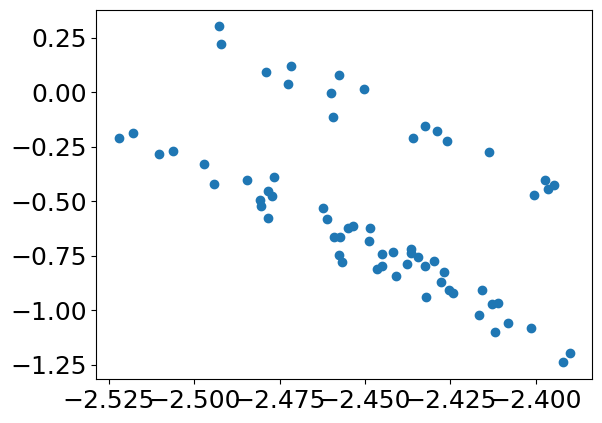

In [114]:
a = 66 * 8
b = a + 66
gd = copy.deepcopy(graph_data2[a:b])
gdx = np.array([gdi.x[0] for gdi in gd])

gd = copy.deepcopy(graph_data2[a:b])
gdy = np.array([gdi.y for gdi in gd])

plt.scatter(gdx[:, 1], gdy)
plt.show()

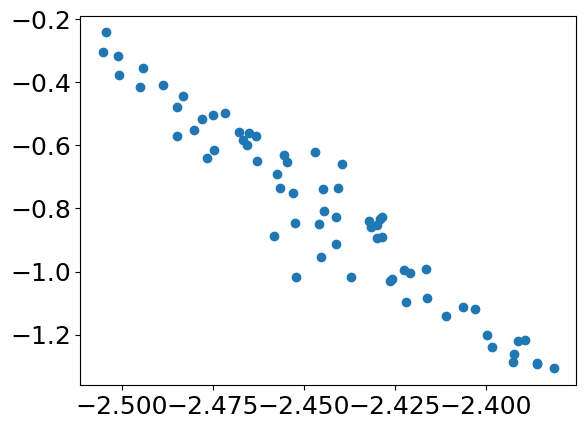

In [115]:
a = 66 * 7
b = a + 66
gd = copy.deepcopy(graph_data2[a:b])
gdx = np.array([gdi.x[0] for gdi in gd])

gd = copy.deepcopy(graph_data2[a:b])
gdy = np.array([gdi.y for gdi in gd])

plt.scatter(gdx[:, 1], gdy)
plt.show()

In [116]:
graph_data2[0:66]

[Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=5, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=